# A gerneral pipeline

## load data


In [3]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import hashlib
import requests
import os

#save
DATA_HUB = dict()
DATA_URL = 'https://www.kaggle.com/c/california-house-prices/data/'

def download(name, cache_dir=os.path.join('..', 'data')): 
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        print(f'file already exist!')
        return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [6]:
DATA_HUB['kaggle_house_train'] = DATA_URL + 'train.csv'
DATA_HUB['kaggle_house_test'] = DATA_URL + 'test.csv'

train_data = pd.read_csv("../data/train.csv.zip",compression='zip')
test_data = pd.read_csv("../data/test.csv.zip",compression='zip')

In [7]:
print(f'{train_data.shape},{test_data.shape}')
print(f'{train_data.columns}\n{test_data.columns}')
print([i for i in train_data.columns if i not in test_data.columns])
print(train_data.dtypes)
print(train_data.iloc[1,:])

(47439, 41),(31626, 40)
Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School', 'Middle School Score', 'Middle School Distance',
       'High School', 'High School Score', 'High School Distance', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Tax assessed value',
       'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')
Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Gar

In [8]:
all_features = pd.concat((train_data.iloc[:, 4:-1], test_data.iloc[:, 3:-1]))
del all_features["Zip"]
all_features.shape

(79065, 35)

In [9]:
## 标准化数字输入
missing_values_count = all_features.isna().sum()
print(missing_values_count.sum())
missing_values_count_percent = missing_values_count/all_features.shape[0]*100
print(missing_values_count_percent)

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
print(all_features[numeric_features].dtypes)


389755
Type                            0.000000
Year built                      2.456207
Heating                        14.561437
Cooling                        19.109593
Parking                         2.119775
Lot                            29.076077
Bedrooms                        5.815468
Bathrooms                       6.842471
Full bathrooms                 16.351104
Total interior livable area     4.904825
Total spaces                    2.108392
Garage spaces                   2.108392
Region                          0.002530
Elementary School              10.741795
Elementary School Score        11.047872
Elementary School Distance     10.741795
Middle School                  35.764245
Middle School Score            35.766774
Middle School Distance         35.764245
High School                     9.073547
High School Score               9.845064
High School Distance            9.074812
Flooring                       27.732878
Heating features               15.870486
Cooling f

In [10]:
# 首先填充日期
print(all_features["Last Sold On"].isna().sum())
all_features["Last Sold On"] = all_features["Last Sold On"].fillna(method='bfill', axis=0).fillna(0)
print(all_features["Last Sold On"].isna().sum())

29545
0


In [11]:
print(all_features["Listed On"].isna().sum())


0


In [12]:
all_features['Listed On'] = pd.to_datetime(all_features['Listed On'], format="%Y-%m-%d")
all_features['Last Sold On'] = pd.to_datetime(all_features['Last Sold On'], format="%Y-%m-%d")
print(all_features['Listed On'].head())
print(all_features['Last Sold On'].head())

0   2019-10-24
1   2019-10-16
2   2019-08-25
3   2019-10-24
4   2019-06-07
Name: Listed On, dtype: datetime64[ns]
0   2019-08-30
1   2019-08-30
2   2016-08-30
3   2016-08-30
4   2016-06-27
Name: Last Sold On, dtype: datetime64[ns]


In [13]:
# 将所有na置0
all_features = all_features.fillna(0)
print(all_features["Last Sold On"].head())
print(all_features.isna().sum().sum())

0   2019-08-30
1   2019-08-30
2   2016-08-30
3   2016-08-30
4   2016-06-27
Name: Last Sold On, dtype: datetime64[ns]
0


In [14]:
all_features.dtypes[all_features.dtypes=='object']

Type                   object
Heating                object
Cooling                object
Parking                object
Bedrooms               object
Region                 object
Elementary School      object
Middle School          object
High School            object
Flooring               object
Heating features       object
Cooling features       object
Appliances included    object
Laundry features       object
Parking features       object
City                   object
dtype: object

In [15]:
print(len(all_features['Type'].unique()))
print(len(all_features['Heating'].unique()))
print(len(all_features['Cooling'].unique()))
print(len(all_features['Parking'].unique()))
print(len(all_features['Bedrooms'].unique()))
print(len(all_features['Region'].unique()))
print(len(all_features['Elementary School'].unique()))
print(len(all_features['Middle School'].unique()))
print(len(all_features['High School'].unique()))
print(len(all_features['Flooring'].unique()))
print(len(all_features['Heating features'].unique()))
print(len(all_features['Cooling features'].unique()))
print(len(all_features['Appliances included'].unique()))
print(len(all_features['Laundry features'].unique()))
print(len(all_features['Parking features'].unique()))
print(len(all_features['City'].unique()))

174
2660
911
9913
278
1259
3568
809
922
1740
1763
596
11290
3031
9695
1122


In [16]:
features = list(numeric_features)
features.append('Type')   # 加上类别数相对较少的Type
print(features)
print(len(features))

['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Type']
18


In [17]:
all_features = all_features[features]
all_features.shape

(79065, 18)

In [18]:
all_features = pd.get_dummies(all_features)
all_features.shape

(79065, 191)

In [70]:
# 转为tensor
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
print(train_features.shape)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
print(test_features.shape)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1,1), dtype=torch.float32)
print(train_labels.shape)

torch.Size([47439, 191])
torch.Size([31626, 191])
torch.Size([47439, 1])


## MLP

In [71]:
from torch import nn
import torch.nn.functional as F

INPUT_DIM = train_features.shape[1]  
HIDDEN_DIM = 256
NUM_CLASSES = 1

LEARNING_RATE = 1e-2
NUM_EPOCHS = 100
BATCH_SIZE = 64
WEIGHT_DECAY = 0.1
K = 5



In [72]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in):
        z = F.relu(self.fc1(x_in)) 
        y_pred = self.fc2(z)
        return y_pred

model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=191, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)>


In [73]:
##to gpu
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
train_features = train_features.to(device)
train_labels = train_labels.to(device)
test_features = test_features.to(device)
model.to(device)




MLP(
  (fc1): Linear(in_features=191, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [74]:
from d2l import torch as d2l
from torch.optim import Adam



def train(model,train_X,train_Y,test_X,test_Y,
          num_epochs,batch_size):
  loss_fn = nn.MSELoss()

  def log_rmse(model, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(model(features), 1, float('inf'))
    rmse = torch.sqrt(loss_fn(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()
   
  optimizer = Adam(model.parameters(), lr=LEARNING_RATE, 
                   weight_decay=WEIGHT_DECAY)
  
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_X, train_Y), batch_size)

  for epoch in range(num_epochs):
    for X, y in train_iter:
      # Forward pass
      X_pred = model(X)

      # Loss
      loss = loss_fn(X_pred,y)

      # Zero all gradients
      optimizer.zero_grad()

      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()

    train_ls.append(log_rmse(model, train_X, train_Y))
    if test_Y is not None:
        test_ls.append(log_rmse(model, test_X, test_Y))
    # if epoch%1==0: 
    #   log_ls = log_rmse(model, train_X, train_Y)
    #   train_ls.append(log_ls)
    #   print (f"Epoch: {epoch} | log_ls: {log_ls:.2f}")
  
  return train_ls, test_ls
  

In [75]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

# 返回训练和验证误差的平均值
def k_fold(k, num_epochs, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, train_features, train_labels)
        train_ls, valid_ls = train(model, *data, num_epochs, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.458570, valid log rmse 0.458411
fold 2, train log rmse 0.447996, valid log rmse 0.432670
fold 3, train log rmse 0.446093, valid log rmse 0.423432
fold 4, train log rmse 0.337088, valid log rmse 0.349671
fold 5, train log rmse 0.364555, valid log rmse 0.430933


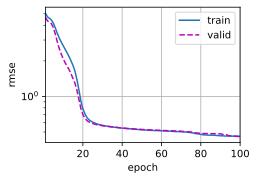

In [76]:

train_l, valid_l = k_fold(k=K,num_epochs=NUM_EPOCHS,batch_size=BATCH_SIZE)



In [2]:
print(f'{K}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

NameError: ignored